In [1]:
import jax
import jax.numpy as jnp
import bayes3d as b
import bayes3d.icp
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# need to fix b.t3d.transform_to_posevec_j base case
# How to preserve camera orientation after if rotational angle is 0?
# openCV defaults to spitting out -2.2214415e+00  2.2214415e+00 since 0, 0 won't work
# can't just spit out 1.e-09 1.e-09 because sometimes you end up looking the wrong way


In [3]:
transform_to_posevec_v_jit = jax.jit(jax.vmap(b.t3d.transform_to_posevec_j))

angle = jnp.pi/2
pose_test = b.t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 1.0]), angle) @ b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 3.0, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
)

print(pose_test)


print(b.t3d.transform_to_posevec(pose_test))


print(b.t3d.transform_to_posevec_j(pose_test))

print(b.t3d.transform_to_posevec(b.t3d.transform_from_posevec(b.t3d.transform_to_posevec(pose_test))))


print(b.t3d.transform_to_posevec(b.t3d.transform_from_posevec(b.t3d.transform_to_posevec_j(pose_test))))

[[-4.9999994e-01 -4.9999997e-01  7.0710677e-01 -2.1213202e+00]
 [-7.0710677e-01  7.0710677e-01  4.3711388e-08 -1.3113416e-07]
 [-4.9999997e-01 -4.9999994e-01 -7.0710677e-01  2.1213202e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[-2.1213202e+00 -1.3113416e-07  2.1213202e+00 -9.1424257e-01
  2.2071767e+00 -3.7869161e-01]
[-2.1213202e+00 -1.3113416e-07  2.1213202e+00 -9.1424263e-01
  2.2071769e+00 -3.7869179e-01]
[-2.1213202e+00 -1.3113416e-07  2.1213202e+00 -9.1424251e-01
  2.2071767e+00 -3.7869158e-01]
[-2.1213202e+00 -1.3113416e-07  2.1213202e+00 -9.1424274e-01
  2.2071772e+00 -3.7869182e-01]


In [4]:
angle = 0
pose_test = b.t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 1.0]), angle) @ b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 3.0, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
)

print(pose_test)


print(b.t3d.transform_to_posevec(pose_test))


print(b.t3d.transform_to_posevec_j(pose_test))

# print(b.t3d.transform_to_posevec(b.t3d.transform_from_posevec(b.t3d.transform_to_posevec(pose_test))))


# print(b.t3d.transform_to_posevec(b.t3d.transform_from_posevec(b.t3d.transform_to_posevec_j(pose_test))))

[[-1.  0.  0.  0.]
 [ 0.  0. -1.  3.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]
[ 0.         3.         0.         0.         2.2214415 -2.2214415]
[0.e+00 3.e+00 0.e+00 1.e-09 1.e-09 1.e-09]


In [5]:
R = pose_test[:3,:3]
eps = 1e-9 #prevent numerical instability, results in mismatch from OpenCV implementation at singularity point theta=0
theta = jnp.clip(jnp.arccos((jnp.trace(R)-1)/2), a_min=eps, a_max=jnp.pi-eps)
pre_vec = jnp.array([(R[2,1]-R[1,2])/(2*jnp.sin(theta)), (R[0,2]-R[2,0])/(2*jnp.sin(theta)), (R[1,0]-R[0,1])/(2*jnp.sin(theta))]) * theta
rvec = pre_vec * theta
rvec += eps
rvec

Array([1.e-09, 1.e-09, 1.e-09], dtype=float32)

In [6]:
pre_vec

Array([-0., -0., -0.], dtype=float32)

In [7]:
theta

Array(3.1415927, dtype=float32)

In [8]:
def pixel_reconstruction(structure, posevec, intrinsics):
    pose = b.t3d.transform_from_posevec(posevec)
    reconstruction = b.project_cloud_to_pixels(b.t3d.apply_transform(structure, b.t3d.inverse_pose(pose)), intrinsics)
    return reconstruction

def loss(structure, posevecs, intrinsics, obs_pixels):
    return ((jax.vmap(pixel_reconstruction, in_axes=(None, 0, None))(structure, posevecs, intrinsics) - obs_pixels)**2).mean()

loss_jit = jax.jit(loss)

gradient_structure_func_jit = jax.jit(jax.grad(loss, argnums=0))
grad_poses_func_jit = jax.jit(jax.grad(loss, argnums=1))

In [9]:
intrinsics = b.Intrinsics(
    height=300,
    width=300,
    fx=200.0,fy=200.0,
    cx=150.0,cy=150.0,
    near=0.001, far=50.0
) 


b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=10.0/1000.0) 




[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (320, 320, 1024)


In [10]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [11]:
IDX = 11
frames = 40
devices = 1
dots = 1000 #250
pc = jnp.array(b.RENDERER.meshes[IDX].vertices)

#b.show_cloud("1",pc)

In [12]:
pc_subsample = pc[jax.random.choice(jax.random.PRNGKey(10), jnp.arange(pc.shape[0]), shape=(dots,) )] 
b.show_cloud("1",pc_subsample)

In [13]:
camera_poses = jnp.array([ 
    b.t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 1.0]), angle) @
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 3.0, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
) for angle in jnp.linspace(0.0, 4*jnp.pi, frames)])


print(camera_poses.shape)

for f in range(frames):
    b.show_pose(str(f), camera_poses[f])

(40, 4, 4)


In [14]:

camera_pose_vecs = transform_to_posevec_v_jit(camera_poses)

print(camera_pose_vecs.shape)

(40, 6)


In [15]:
#check poses can be inverted properly
recovered_camera_poses = []
for pv in camera_pose_vecs:
    recovered_camera_poses.append(b.t3d.transform_from_posevec(pv))

b.clear()
b.show_cloud("1", pc_subsample)
for f in range(frames):
    b.show_pose(str(f), recovered_camera_poses[f])

In [16]:
#rodrigues_from_rotation(rot_mats[1][:3,:3])

In [17]:
def pixel_reconstruction(structure, posevec, intrinsics):
    pose = b.t3d.transform_from_posevec(posevec)
    reconstruction = b.project_cloud_to_pixels(b.t3d.apply_transform(structure, b.t3d.inverse_pose(pose)), intrinsics)
    return reconstruction

def loss(structure, posevecs, intrinsics, obs_pixels):
    return ((jax.vmap(pixel_reconstruction, in_axes=(None, 0, None))(structure, posevecs, intrinsics) - obs_pixels)**2).mean()

In [18]:
pixels_1 = pixel_reconstruction(pc_subsample,camera_pose_vecs[1],intrinsics)
pixels_2 = pixel_reconstruction(pc_subsample,camera_pose_vecs[2],intrinsics)

print(pixels_1)

[[143.27023  68.21384]
 [178.66226 220.58336]
 [120.9787  169.66284]
 ...
 [142.31625 208.99133]
 [121.45047 194.54617]
 [163.05267 110.01608]]


In [19]:
b.clear()
b.show_cloud("1", pc_subsample)
b.show_pose("2", b.t3d.transform_from_posevec(pose_vecs[1]))

NameError: name 'pose_vecs' is not defined

In [20]:
pixels_1.shape

(1000, 2)

In [21]:
pixels_2.shape

(1000, 2)

In [22]:
b.clear()
b.show_cloud("1",pc_subsample)
b.show_pose("1", camera_poses[1])

In [23]:
def render_point_light(pose_vec, structure):#, intrinsics):
    pose = b.t3d.transform_from_posevec(pose_vec)
    inv_pose = b.t3d.inverse_pose(pose)



    image = b.render_point_cloud(b.t3d.apply_transform(structure, inv_pose), intrinsics, pixel_smudge=0.5)

    '''
    reconstruction = b.project_cloud_to_pixels(b.t3d.apply_transform(structure, inv_pose), intrinsics)
    r_image = jnp.zeros((intrinsics.height, intrinsics.width)) 
    indices = jnp.round(reconstruction).astype(int) #reorder the indices 
    indices = tuple(np.array(list(zip(*indices))))
    r_image = r_image.at[indices[1], indices[0]].set(1)
    '''
    
    return image #, r_image

gpus = jax.devices('gpu')
render_point_light_parallel_jit = jax.jit(jax.vmap(render_point_light, in_axes=(0,0)))

In [24]:
# check the 0th pose vec
camera_pose_vecs[0]

# as inversions are cycled through, this breaks


Array([0.e+00, 3.e+00, 0.e+00, 1.e-09, 1.e-09, 1.e-09], dtype=float32)

In [25]:
pc_subsamples = jnp.repeat(pc_subsample[jnp.newaxis, :], frames, axis=0)
oo = render_point_light(camera_pose_vecs[1], pc_subsamples[1])#, intrinsics) #THE 0th vector is still messed up

<Figure size 640x480 with 0 Axes>

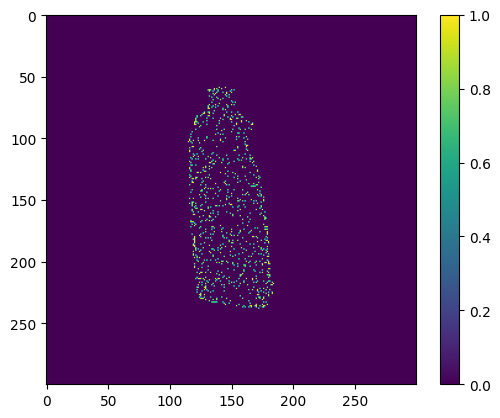

<Figure size 640x480 with 0 Axes>

In [26]:
plt.imshow(jnp.any(oo,axis=2)*1.0) #this is just a plotting bug
plt.colorbar()
plt.figure()
# plt.imshow(im)
# plt.figure()
# plt.imshow(oo>0)

In [27]:
camera_pose_vecs = jnp.array(camera_pose_vecs)

frames_bundle = [1, 2]
images_no_noise = render_point_light_parallel_jit(camera_pose_vecs[frames_bundle, ...], pc_subsamples[frames_bundle, ...])#, intrinsics)
vizf = [b.get_depth_image(1.0 - jnp.any(point_light_image,axis=2), cmap=matplotlib.colormaps['Greys']) for point_light_image in images_no_noise ]

images_no_noise = render_point_light_parallel_jit(camera_pose_vecs, pc_subsamples)
viz = [b.get_depth_image(1.0 - jnp.any(point_light_image,axis=2), cmap=matplotlib.colormaps['Greys']) for point_light_image in images_no_noise ]

In [28]:
vizf[0].save('bundle_frame_1.png')
vizf[1].save('bundle_frame_2.png')

In [29]:
b.make_gif_from_pil_images(viz, "bundle_video.gif")

### Solve Bundle Adjustment

In [30]:
K = jnp.array([
    [intrinsics.fx, 0.0, intrinsics.cx],
    [0.0, intrinsics.fy,  intrinsics.cy],
    [0.0, 0.0, 1.0],
])

E, _ = cv2.findEssentialMat(np.array(pixels_1), np.array(pixels_2), np.array(K))

points, R, t, mask = cv2.recoverPose(E, np.array(pixels_1), np.array(pixels_2), np.array(K), 10000.0)

baseline_transform = b.t3d.inverse_pose(b.t3d.transform_from_rot_and_pos(R,t))

P_0 = K @ jnp.hstack([jnp.eye(3), jnp.zeros((3,1))])
P_1 = K @ jnp.hstack([R, t.reshape(-1,1)])

in_1 = np.array(pixels_1).transpose()
in_2 = np.array(pixels_2).transpose()
points_homogenous = cv2.triangulatePoints(
    np.array(P_0), np.array(P_1), np.array(pixels_1).transpose(), np.array(pixels_2).transpose()
).transpose()
points_3d = points_homogenous[:,:3] / points_homogenous[:,3].reshape(-1,1)


print(jnp.abs(pixel_reconstruction(points_3d, b.t3d.transform_to_posevec_j(jnp.eye(4)),intrinsics) - pixels_1).sum())
print(jnp.abs(pixel_reconstruction(points_3d, b.t3d.transform_to_posevec_j(baseline_transform),intrinsics) - pixels_2).sum())


b.clear()
b.show_cloud("structure", points_3d)
b.show_pose("1", jnp.eye(4))
b.show_pose("2", baseline_transform)

0.00365448
0.011726379


In [35]:
# This must be confusing why i multiply by baseline_transform. But its because in pose_estimates,
# i can't have the identity pose. It is problematic for gradients for some reason.

# i assume this is due to degeneracy of identity


structure_estimate = b.t3d.apply_transform(jnp.array(points_3d), baseline_transform)
pose_estimates = jnp.array(
    [
        b.t3d.transform_to_posevec_j(jnp.eye(4) @ baseline_transform) + 1e-2*jnp.array([0,0,0,1,1,1]),
        b.t3d.transform_to_posevec_j(baseline_transform @ baseline_transform) + 1e-2*jnp.array([0,0,0,1,1,1])
    ]
)
obs_pixels = jnp.stack([pixels_1, pixels_2])

print(loss_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels))
print( gradient_structure_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels))
print(grad_poses_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels))

4.5427103
[[-0.16892223  0.19262943 -0.05559651]
 [-0.03261606  0.10297225 -0.08674394]
 [-0.06903072  0.1293626  -0.10051215]
 ...
 [-0.03881698  0.10877004 -0.09374332]
 [-0.05536797  0.13972197 -0.12369407]
 [-0.13287932  0.14742099 -0.06097146]]
[[ 51.039204 -72.14116   32.956062 253.66214  172.70415   21.160376]
 [ 35.355427 -68.2888    56.775677 266.43057  156.21838   38.48056 ]]


In [36]:
print(gradient_structure_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels))

[[-0.16892223  0.19262943 -0.05559651]
 [-0.03261606  0.10297225 -0.08674394]
 [-0.06903072  0.1293626  -0.10051215]
 ...
 [-0.03881698  0.10877004 -0.09374332]
 [-0.05536797  0.13972197 -0.12369407]
 [-0.13287932  0.14742099 -0.06097146]]


In [37]:
learning_rate= 0.00001
for i in range(10000):
    loss_value = loss_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels)
    grad_structure = gradient_structure_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels)
    structure_estimate -= learning_rate * grad_structure
    grad_poses = grad_poses_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels)
    pose_estimates -= learning_rate * grad_poses
    loss_value = loss_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels)
    print(loss_value)
    if loss_value < 0.0001:
        print("Loss is low enough!")
        break

2.6957588
1.620105
0.9923594
0.62506324
0.40946725
0.28227356
0.20672409
0.16136606
0.1336801
0.11636909
0.105166115
0.09756615
0.09211131
0.08794165
0.084553696
0.081652634
0.07906319
0.07668064
0.074444264
0.072317615
0.07027848
0.068312556
0.06641101
0.06456811
0.062779985
0.0610438
0.05935775
0.057718623
0.056126118
0.05457817
0.053073276
0.051610377
0.050188906
0.048806384
0.04746319
0.046156727
0.044886522
0.04365212
0.04245177
0.041284937
0.04015082
0.039047915
0.037976116
0.036933985
0.035920992
0.03493629
0.033978485
0.033047564
0.032142628
0.031262603
0.030407272
0.029575812
0.028767074
0.027980898
0.027216673
0.026474025
0.025751285
0.025049184
0.024366116
0.023702411
0.023057187
0.022429423
0.021819538
0.021226343
0.0206497
0.020088878
0.019543592
0.019013572
0.01849817
0.017996885
0.017509893
0.017036052
0.016575627
0.016127804
0.01569232
0.01526882
0.014857422
0.014457081
0.014067795
0.013689399
0.013321523
0.0129638985
0.012616115
0.012277974
0.011949211
0.011629168
0.01

In [38]:
b.clear()
b.show_pose("1", b.t3d.transform_from_posevec(pose_estimates[0]))
b.show_pose("2", b.t3d.transform_from_posevec(pose_estimates[1]))
b.show_cloud("3",structure_estimate)

In [52]:
## integrate these results with ransac eventually

# blue in meshcat visualization corresponds to z axis

In [53]:
# add back to pose convention converter

# eps = 1e-9
# return eps*jnp.ones((3,3)) + R